In [211]:
%matplotlib inline
#%matplotlib 

In [212]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import torch
import scipy
import torch.nn as nn
import scipy.ndimage as nd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np


from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import copy
import time

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [213]:
#Download mnist data
data_train = MNIST("./data/mnist",
                   download=True,
                   train=True,
                   transform=transforms.Compose([transforms.ToTensor()]))

data_val = MNIST("./data/mnist",
                 train=False,
                 download=True,
                 transform=transforms.Compose([transforms.ToTensor()]))

dataloader_train = DataLoader(
    data_train, batch_size=1000, shuffle=True, num_workers=8)
dataloader_val = DataLoader(data_val, batch_size=1000, num_workers=8)

dataloaders = {
    "train": dataloader_train,
    "val": dataloader_val,
}

digit_one, _ = data_val[5]

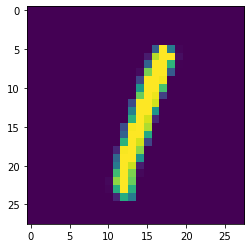

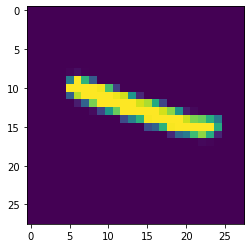

In [214]:
#Single digit test 
plt.imshow(digit_one.reshape(28,28))
plt.show()

def rotate_img(x, deg):
    rot_img = scipy.ndimage.rotate(x,deg,reshape=False)
    return rot_img

#Example rotation of digit one by 90 degrees
rot_one = rotate_img(digit_one.reshape(28,28),90)

tens_rot_one = rot_one
plt.imshow(tens_rot_one)
plt.show()

In [215]:
#Setup/utility functions
def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device

def one_hot_embedding(labels, num_classes=10):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

#Check GPU available
device = get_device()
print(device)

cuda:0


In [216]:
#Loss Functions
def relu_evidence(y):
    return F.relu(y)

def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl

def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)

    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div

def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


In [217]:
#2018 EDL Implementation
class InferNet(nn.Module):
    def __init__(self, sample_shape, num_classes, dropout=0.5):
        super().__init__()
        if len(sample_shape) == 1:
            self.conv = nn.Sequential()
            fc_in = sample_shape[0]
        else:  # 3
            dims = [sample_shape[0], 20, 50]
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=dims[0], out_channels=dims[1], kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
                nn.Conv2d(in_channels=dims[1], out_channels=dims[2], kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
            )
            fc_in = sample_shape[1] // 4 * sample_shape[2] // 4 * dims[2]

        fc_dims = [fc_in, min(fc_in, 500), num_classes]
        self.fc = nn.Sequential(
            nn.Linear(fc_dims[0], fc_dims[1]),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(fc_dims[1], fc_dims[2]),
            nn.ReLU(),
        )

    def forward(self, x):
        out_conv = self.conv(x).view(x.shape[0], -1)
        evidence = self.fc(out_conv)
        return evidence



def train_model(
    model,
    dataloaders,
    num_classes,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=30,
    device=None,
    uncertainty=False,
):

    since = time.time()

    if not device:
        device = get_device()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        y = one_hot_embedding(labels, num_classes)
                        y = y.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(
                            outputs, y.float(), epoch, num_classes, 10, device
                        )

                        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))
                        acc = torch.mean(match)
                        evidence = relu_evidence(outputs)
                        alpha = evidence + 1
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

                        total_evidence = torch.sum(evidence, 1, keepdim=True)
                        mean_evidence = torch.mean(total_evidence)
                        mean_evidence_succ = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * match
                        ) / torch.sum(match + 1e-20)
                        mean_evidence_fail = torch.sum(
                            torch.sum(evidence, 1, keepdim=True) * (1 - match)
                        ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None:
                if phase == "train":
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())                
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'mnist_EDL_model.pyt')

    metrics = (losses, accuracy)

    return model, metrics


In [218]:
#Train Model or Load Pre-Trained
model = None
train = True 
if(train):
    #Initalise and train Model & Validate

    num_epochs = 50
    use_uncertainty = True
    num_classes = 10

    #model = LeNet(num_classes, digit_one.shape,dropout=True) 

    model = InferNet(digit_one.shape,num_classes)
    if use_uncertainty:
        criterion = edl_digamma_loss
        #criterion = edl_loss
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.005)

    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    device = get_device()
    model = model.to(device)

    model, metrics = train_model(
        model,
        dataloaders,
        num_classes,
        criterion,
        optimizer,
        scheduler=exp_lr_scheduler,
        num_epochs=num_epochs,
        device=device,
        uncertainty=use_uncertainty,
    )

    state = {
        "epoch": num_epochs,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }

else:
    #Load Pre-Trained Model 
    num_classes = 10
    #model = LeNet(num_classes, digit_one.shape,dropout=True) 
    model = InferNet(digit_one.shape,num_classes)

    model.load_state_dict(torch.load('mnist_EDL_model.pyt'))
    model.eval()

Epoch 0/49
----------
Train loss: 1.4544 acc: 0.6182
Val loss: 0.6405 acc: 0.9047

Epoch 1/49
----------
Train loss: 0.7527 acc: 0.9075
Val loss: 0.5453 acc: 0.9458

Epoch 2/49
----------
Train loss: 0.6149 acc: 0.9419
Val loss: 0.4809 acc: 0.9621

Epoch 3/49
----------
Train loss: 0.5630 acc: 0.9524
Val loss: 0.4625 acc: 0.9652

Epoch 4/49
----------
Train loss: 0.5436 acc: 0.9559
Val loss: 0.4375 acc: 0.9681

Epoch 5/49
----------
Train loss: 0.5324 acc: 0.9583
Val loss: 0.4479 acc: 0.9700

Epoch 6/49
----------
Train loss: 0.5175 acc: 0.9600
Val loss: 0.4306 acc: 0.9707

Epoch 7/49
----------
Train loss: 0.4827 acc: 0.9663
Val loss: 0.4074 acc: 0.9744

Epoch 8/49
----------
Train loss: 0.4741 acc: 0.9674
Val loss: 0.4075 acc: 0.9750

Epoch 9/49
----------
Train loss: 0.4809 acc: 0.9679
Val loss: 0.4165 acc: 0.9741

Epoch 10/49
----------
Train loss: 0.4877 acc: 0.9682
Val loss: 0.4221 acc: 0.9750

Epoch 11/49
----------
Train loss: 0.4817 acc: 0.9688
Val loss: 0.4186 acc: 0.9762

Ep

In [219]:
#Do things with trained model
print(digit_one.shape)
def model_predict(model, input):
    input = input.to(device)
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        output = model(input)
        evidence = relu_evidence(output)
        alpha = evidence + 1
        uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
        _, preds = torch.max(output, 1)
        prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
        #correct, num_samples = 0, 0
        #evidence, loss = model(digit.to(device))
        #prediction = torch.sum(evidence.argmax(dim=-1))
    return prob, preds, uncertainty

rotated_one = rotate_img(digit_one.reshape(28,28),50)
rotated_one = torch.tensor(rotated_one[None, :])


prob, preds,uncertainty = model_predict(model,rotated_one)
#print(prob.cpu()[0].numpy())
print(uncertainty)
print(prob)


torch.Size([1, 28, 28])
tensor([[1.]], device='cuda:0')
tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]], device='cuda:0')


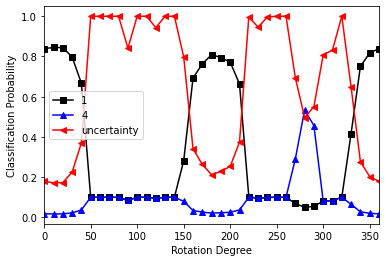

In [220]:
use_uncertainty = True
def rotating_image_classification(
    model, img, uncertainty=True, threshold=0.5, device=None):
    if not device:
        device = get_device()
    num_classes = 10
    Mdeg = 360
    Ndeg = int(Mdeg / 10) + 1
    ldeg = []
    lp = []
    lu = []
    classifications = []

    scores = np.zeros((1, num_classes))
    rimgs = np.zeros((28, 28 * Ndeg))
    for i, deg in enumerate(np.linspace(0, Mdeg, Ndeg)):
        nimg = rotate_img(img.numpy()[0], deg).reshape(28, 28)
        nimg = np.clip(a=nimg, a_min=0, a_max=1)
        rimgs[:, i * 28 : (i + 1) * 28] = nimg
        trans = transforms.ToTensor()
        img_tensor = trans(nimg)
        img_tensor.unsqueeze_(0)
        img_variable = torch.autograd.Variable(img_tensor)
        img_variable = img_variable.to(device)

        if uncertainty:
            output = model(img_variable)
            evidence = relu_evidence(output)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(output, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            classifications.append(preds[0].item())
            lu.append(uncertainty.mean().tolist())
        else:
            output = model(img_variable)
            _, preds, = torch.max(output, 1)
            prob = F.softmax(output, dim=1)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            classifications.append(preds[0].item())

        scores += prob.detach().cpu().numpy() >= threshold
        ldeg.append(deg)
        lp.append(prob.tolist())

    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:, labels]
    c = ["black", "blue", "red", "brown", "purple", "cyan"]
    marker = ["s", "^", "o"] * 2
    labels = labels.tolist()
    #fig = plt.figure(figsize=[6.2, 5])
    #fig, axs = plt.subplots(3, gridspec_kw={"height_ratios": [4, 1, 12]})

    for i in range(len(labels)):
        plt.plot(ldeg, lp[:, i], marker=marker[i], c=c[i])

    if uncertainty:
        labels += ["uncertainty"]
        plt.plot(ldeg, lu, marker="<", c="red")

    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

    """  axs[0].set_title('Rotated "1" Digit Classifications')
    axs[0].imshow(1 - rimgs, cmap="gray")
    axs[0].axis("off")
    plt.pause(0.001)

    empty_lst = []
    empty_lst.append(classifications)
    axs[1].table(cellText=empty_lst, bbox=[0, 1.2, 1, 1])
    axs[1].axis("off")

    axs[2].legend(labels)
    axs[2].set_xlim([0, Mdeg])
    axs[2].set_ylim([0, 1])
    axs[2].set_xlabel("Rotation Degree")
    axs[2].set_ylabel("Classification Probability") """

model.eval()

rotating_image_classification(
    model, digit_one, uncertainty=use_uncertainty
)


In [330]:
""" def step_EDL(action,state,timestep,model,input):
    new_state = state
    if(action>0): 
        new_state[1] = new_state[1] + action
        if(new_state[1]>359):
            new_state[1] = new_state[1]-360
            #done = True
        #new_state[0] = min(state[0] + 1,180)
    elif(action<0):
        new_state[1] = new_state[1] - action
        if(new_state[1]<0):
            new_state[1] = 360+new_state[1]
       # new_state[0] = max(state[0] - 1,0)

    old_rotated_one = rotate_img(input.reshape(28,28),state[1])
    old_rotated_one = torch.tensor(old_rotated_one[None, :])
    _,_,old_uncertainty = model_predict(model,old_rotated_one)

    new_rotated_one = rotate_img(input.reshape(28,28),new_state[1])
    new_rotated_one = torch.tensor(new_rotated_one[None, :])
    prob, preds,uncertainty = model_predict(model,new_rotated_one)
    #new_state[1] = preds.item()
    #reward = 1-uncertainty.item()

    delta =  2.5 -1.001**timestep
    if(timestep==0):
        reward = 0
    else:
        reward = (1-uncertainty.item())-delta*(uncertainty.item() - old_uncertainty.item())

    
    return new_state, reward, preds.item()  """
        

def step_EDL(action,state,timestep,model,input):
    #done = False
    new_state = state
    if(action==0): 
        if(state[1]==359):
            new_state[1] = 0
        else:
            new_state[1] += 1
            #done = True
        #new_state[0] = min(state[0] + 1,180)
    elif(action==1):
        if(state[1]==0):
            new_state[1] = 359
        else:
            new_state[1] += -1
       # new_state[0] = max(state[0] - 1,0)
        
    
    old_rotated_one = rotate_img(input.reshape(28,28),state[1])
    old_rotated_one = torch.tensor(old_rotated_one[None, :])
    _,_,old_uncertainty = model_predict(model,old_rotated_one)

    new_rotated_one = rotate_img(input.reshape(28,28),new_state[1])
    new_rotated_one = torch.tensor(new_rotated_one[None, :])
    prob, preds,uncertainty = model_predict(model,new_rotated_one)
    #new_state[1] = preds.item()
    #reward = 1-uncertainty.item()

    delta = 2.5 -1.001**timestep
    if(timestep==0):
        reward = 0
    else:
        reward = (1-uncertainty.item()) #-delta*(uncertainty.item() - old_uncertainty.item())
    return new_state, reward, preds.item()

#step_EDL(action=1, state=[50,250],timestep = 10, model = model, input=digit_one)


In [310]:
from IPython.display import clear_output
past_actions = []
past_rewards = []
episode_len = 720
def plot_metrics(states, reward, action, action_dist, n_ep,ep_reward):
    #past_rewards.append(reward)
    clear_output(wait=True)
    plt.figure(1)
    plt.clf()
    plt.title('Reward Values for Episode '+str(n_ep) + ', Total Reward= '+ str(ep_reward))
    plt.xlabel('Timestemp')
    plt.ylabel('Reward Value')
    plt.plot(reward)


    plt.figure(2)
    plt.clf()
    #rotations_t = torch.tensor(states, dtype=torch.float)
    plt.title('Training States for Episode '+str(n_ep))
    plt.xlabel('Timestep')
    plt.ylabel('Rotation Degree')
    plt.plot(states)
    plt.ylim([0, 360])

    plt.figure(3)
    plt.clf()
    plt.title('Action Probability Distribution for Episode '+str(n_ep))
    names = ['Increase', 'Decrease', 'Maintain']
    plt.bar(names,action_dist)

    past_actions.append(np.mean(action))
    plt.figure(4)
    plt.clf()
    plt.title('Running Mean of Previous Actions at Episode '+str(n_ep))
    plt.xlabel('Episode')
    plt.ylabel('Action Value')
    plt.plot(past_actions)


    # Take 100 episode averages and plot them too
    #if len(rotations_t) >= 100:
    #    means = rotations_t.unfold(0, 100, 1).mean(1).view(-1)
    #    means = torch.cat((torch.zeros(99), means))
    #    plt.plot(means.numpy())
    #    return(means)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython and False:
        display.clear_output(wait=True)
        display.display(plt.gcf())



In [417]:
from torch.distributions import Categorical
import random
from torch.nn.functional import normalize 
keep_state = []
past_actions.clear()
past_rewards.clear()

# Q-table is replaced by a neural network
class Agent(nn.Module):
    def __init__(self, observation_space_size: int, action_space_size: int, hidden_size: int):
        super(Agent, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=observation_space_size, out_features=hidden_size, bias=True),
            nn.PReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True),
            nn.PReLU(),
            nn.Linear(in_features=hidden_size, out_features=action_space_size, bias=True)
        )

    def forward(self, x):
        x = normalize(x, dim=1)
        x = self.net(x)
        return x

agent = Agent(2,3,20)
action_logits = agent(torch.tensor(state).float().unsqueeze(dim=0))
action = Categorical(logits=action_logits).sample()
print(action_logits)


tensor([2])


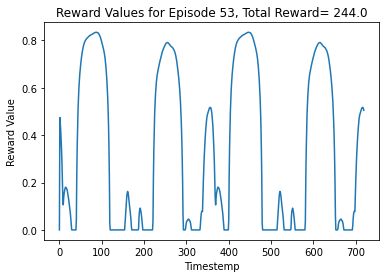

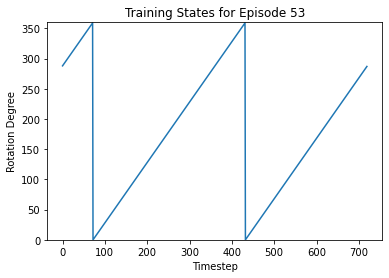

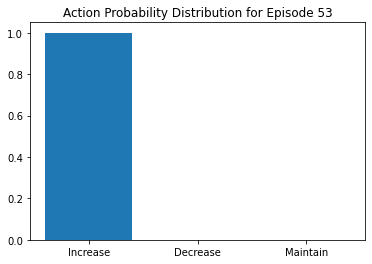

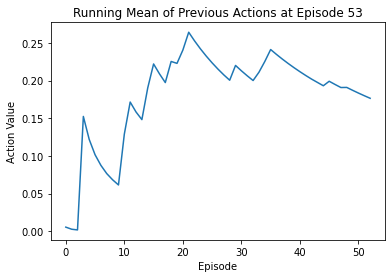

KeyboardInterrupt: 

In [409]:
#Reinforcement Learning Trial 
from collections import deque
from torch.distributions import Categorical
import random
keep_state = []
past_actions.clear()
past_rewards.clear()

# define policy network
class policy_net(nn.Module):
    def __init__(self, nS, nH, nA): # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
        super(policy_net, self).__init__()
        self.h = nn.Linear(nS, nH)
        self.out = nn.Linear(nH, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        x = F.relu(self.h(x))
        x = F.softmax(self.out(x), dim=1)
        return x

# instantiate the policy
input_dig = digit_one
nStates = 2
nActions = 3 
nHidden = 1

policy = policy_net(nStates, nHidden, nActions)

# create an optimizer
optimizer = torch.optim.Adam(policy.parameters())
gamma=1
n_episode = 1
returns = deque(maxlen=800)
render_rate = 100 

keep_preds = []
keep_actions = []
for episode in range(0,800):
    rewards = []
    actions = []
    states  = []
    curr_angle = []

    preds = []
    eps_action_dists = np.array([0,0,0])
    action_dist = np.array([])
    spawn_rotation = random.randint(0,360)
    current_rotation = spawn_rotation
    state = [spawn_rotation, current_rotation]
    ep_len = 0
    for it in range(0,episode_len):
        # calculate probabilities of taking each action
        probs = policy(torch.tensor(state).unsqueeze(0).float())
        eps_action_dists = eps_action_dists + probs.detach()[0].numpy()

        # sample an action from that set of probs
        sampler = Categorical(probs)
        action = sampler.sample()
        action = action.item()
        #!!!change 
        #if(state[0] == 0):
        #    action = 2 
        #else:
        #    action = 1
        
        # use that action in the environment
        #new_state, reward, done, info = env.step(action.item())
        new_state, reward, pred = step_EDL(action,state,it,model,input_dig)
        state = new_state

        keep_state.append(state)
        states.append(state)
        curr_angle.append(state[1])
        actions.append(action)
        rewards.append(reward)
        preds.append(pred)

        ep_len += 1

    rewards = np.array(rewards)

    R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))])
    #R = torch.sum(torch.tensor(rewards))
    #print(R) 

    keep_preds.append(preds)
    keep_actions.append(actions)

    states = torch.tensor(states).float()
    actions = torch.tensor(actions)

    # calculate gradient
    probs = policy(states)
    sampler = Categorical(probs)
    log_probs = -sampler.log_prob(actions)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
    pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
    
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    # calculate average return and print it out
    returns.append(np.sum(rewards))
    #print(returns)
    keep_state = []
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))    
    #plot_metrics(states,rewards,n_episode)
    mean_action_dist = eps_action_dists/episode_len
    #print(curr_angle)
    plot_metrics(curr_angle,rewards, np.mean(keep_actions),mean_action_dist, n_episode, np.round(np.sum(rewards)))
    
    #print(np.mean(keep_actions))
    n_episode += 1


# close environment
